Imports

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import time
import sys
import tables
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score,precision_score,recall_score
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob
from collections import Counter
import nltk
import re
from scipy.sparse import hstack, csr_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from decouple import config
from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextGenParameters
from tqdm import tqdm



# Hit Song prediction based on lyrics

### 1.1 Useful Helper Functions
We've collected all our helper functions here, so they don't clutter up the rest of the notebook

In [14]:
def analyze_title_mismatches_Spotify(df_spotify, df_billboard):
    """
    Analyze potential title mismatches between MSD and Billboard datasets
    """
    # Create clean versions for analysis
    df_spotify['clean_title'] = df_spotify['song'].str.lower().str.strip()
    df_billboard['clean_title'] = df_billboard['song'].str.lower().str.strip()
    
    # Basic statistics
    print("Title Statistics:")
    print(f"Million Song Dataset unique titles: {df_spotify['clean_title'].nunique()}")
    print(f"Billboard unique titles: {df_billboard['clean_title'].nunique()}")
    
    # Check for exact matches
    songs_titles = set(df_spotify['clean_title'])
    billboard_titles = set(df_billboard['clean_title'])
    exact_matches = songs_titles.intersection(billboard_titles)
    
    print(f"\nExact title matches: {len(exact_matches)}")
    print(f"Match percentage: {len(exact_matches)/len(billboard_titles)*100:.2f}% of Billboard titles")
    
    # Check for common patterns in title formatting differences
    # 1. Special characters and punctuation
    df_spotify['title_no_punct'] = df_spotify['clean_title'].str.replace(r'[^\w\s]', '', regex=True)
    df_billboard['title_no_punct'] = df_billboard['clean_title'].str.replace(r'[^\w\s]', '', regex=True)
    
    songs_titles_no_punct = set(df_spotify['title_no_punct'])
    billboard_titles_no_punct = set(df_billboard['title_no_punct'])
    punct_matches = songs_titles_no_punct.intersection(billboard_titles_no_punct)
    
    print(f"\nMatches after removing punctuation: {len(punct_matches)}")
    print(f"Additional matches: {len(punct_matches) - len(exact_matches)}")
    
    # 2. Featured artists in title
    df_spotify['title_no_feat'] = df_spotify['clean_title'].str.replace(r'feat\.?|ft\.?|featuring', '', regex=True).str.strip()
    df_billboard['title_no_feat'] = df_billboard['clean_title'].str.replace(r'feat\.?|ft\.?|featuring', '', regex=True).str.strip()
    
    songs_titles_no_feat = set(df_spotify['title_no_feat'])
    billboard_titles_no_feat = set(df_billboard['title_no_feat'])
    feat_matches = songs_titles_no_feat.intersection(billboard_titles_no_feat)
    
    print(f"\nMatches after removing featuring artists: {len(feat_matches)}")
    print(f"Additional matches: {len(feat_matches) - len(punct_matches)}")
    
    # 3. Sample of mismatches for investigation
    print("\nSample potential near-matches (for manual investigation):")
    
    # Find Billboard titles that have no exact match but might be similar
    unmatched_billboard = billboard_titles - exact_matches
    
    # Simple similarity check (contains partial string)
    sample_count = 0
    for b_title in list(unmatched_billboard)[:100]:  # Check first 100 unmatched
        for s_title in songs_titles:
            # Check if one is contained in the other
            if (b_title in s_title or s_title in b_title) and len(b_title) > 3 and len(s_title) > 3:
                print(f"Billboard: '{b_title}' <-> MSD: '{s_title}'")
                sample_count += 1
                if sample_count >= 10:  # Show 10 examples
                    break
        if sample_count >= 10:
            break
    
    return {
        'exact_matches': len(exact_matches),
        'punct_matches': len(punct_matches),
        'feat_matches': len(feat_matches),
        'billboard_titles': len(billboard_titles),
        'song_titles': len(songs_titles)
    }

In [15]:
def merge_spotify_data_with_billboard(df_spotify, df_billboard):
    """
    Merge song data from spotify Dataset with Billboard Hot 100 data
    based on song title and potentially artist name for better matching.
    Only includes songs from the earliest Billboard year onwards.
    Uses a composite approach to handle duplicate billboard entries.
    
    Parameters:
    - df_spotify: DataFrame with 60,000 spotify songs
    - df_billboard: DataFrame with Billboard Hot 100 data
    
    Returns:
    - DataFrame with merged data and "is_hit" indicator
    """

    # Clean titles in both dataframes for better matching
    df_spotify['clean_title'] = df_spotify['song'].str.lower().str.strip()
    df_billboard['clean_title'] = df_billboard['song'].str.lower().str.strip()
    

    date_columns = [col for col in df_billboard.columns if 'date' in col.lower()]
    
    if date_columns:
        date_col = date_columns[0]
        # Convert to datetime if not already
        if df_billboard[date_col].dtype != 'datetime64[ns]':
            df_billboard[date_col] = pd.to_datetime(df_billboard[date_col], errors='coerce')
        
        # Get the earliest year from Billboard
        earliest_billboard_date = df_billboard[date_col].min()
        earliest_billboard_year = earliest_billboard_date.year
        print(f"Earliest Billboard year: {earliest_billboard_year}")
    # Step 3: Group Billboard data to handle multiple appearances of the same song
    # First check if we have the necessary columns
    required_columns = ['clean_title', 'artist']
    has_required_columns = all(col in df_billboard.columns for col in required_columns)
    
    if has_required_columns:
        # Create lists of columns to aggregate
        agg_dict = {}
        
        # Always include these if available
        if 'peak-rank' in df_billboard.columns:
            agg_dict['peak-rank'] = 'min'  # Best (lowest) position
        
        if 'weeks-on-board' in df_billboard.columns:
            agg_dict['weeks-on-board'] = 'max'  # Total weeks
        
        if date_col in df_billboard.columns:
            agg_dict[date_col] = 'min'  # First appearance
        
        # Group by song and artist to aggregate across multiple chart appearances
        print("Grouping Billboard data to handle multiple appearances...")
        billboard_grouped = df_billboard.groupby(['clean_title', 'artist']).agg(agg_dict).reset_index()
        
        # Add marker column for identifying hits
        billboard_grouped['in_billboard'] = 1
        
        print(f"Original Billboard entries: {len(df_billboard)}")
        print(f"Grouped Billboard entries: {len(billboard_grouped)}")
        
        # Use the grouped data for merging
        df_billboard_for_merge = billboard_grouped
    else:
        print("Warning: Required columns for grouping not found. Using original Billboard data.")
        # Add marker column
        df_billboard['in_billboard'] = 1
        df_billboard_for_merge = df_billboard
    
    # Step 4: Remove duplicates in song dataset (if any)
    df_spotify = df_spotify.drop_duplicates(subset=['clean_title', 'artist'], keep='first')
    
    # Step 5: Perform the merge
    if 'artist' in df_spotify.columns and 'artist' in df_billboard_for_merge.columns:
        df_spotify['clean_artist'] = df_spotify['artist'].str.lower().str.strip()
        df_billboard_for_merge['clean_artist'] = df_billboard_for_merge['artist'].str.lower().str.strip()
        
        # Merge on both title and artist
        merged_df = pd.merge(
            df_spotify,
            df_billboard_for_merge,
            how='left',  # Keep all songs, even those not in Billboard
            left_on=['clean_title', 'clean_artist'],
            right_on=['clean_title', 'clean_artist'],
            suffixes=('_song', '_billboard')
        )
    else:
        # Merge on title only
        merged_df = pd.merge(
            df_spotify,
            df_billboard_for_merge,
            how='left',  # Keep all songs, even those not in Billboard
            left_on='clean_title',
            right_on='clean_title',
            suffixes=('_song', '_billboard')
        )
    
    # Step 6: Create hit indicators
    merged_df['is_hit'] = merged_df['in_billboard'].fillna(0).astype(int)
    
    # Optional: Create more specific hit indicators
    if 'peak-rank' in merged_df.columns:
        merged_df['is_top10'] = merged_df['peak-rank'].apply(
            lambda x: 1 if pd.notnull(x) and x <= 10 else 0
        )
        merged_df['is_top40'] = merged_df['peak-rank'].apply(
            lambda x: 1 if pd.notnull(x) and x <= 40 else 0
        )
    
    # Step 7: Clean up temporary columns
    columns_to_drop = ['clean_title', 'in_billboard']
    if 'clean_artist' in merged_df.columns:
        columns_to_drop.append('clean_artist')
    if 'song' in merged_df.columns:
        columns_to_drop.append('song')
    if 'artist' in merged_df.columns:
        columns_to_drop.append('artist')
    
    merged_df = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])
    
    # Print summary of results
    hit_count = merged_df['is_hit'].sum()
    total_count = len(merged_df)
    hit_percentage = hit_count / total_count * 100 if total_count > 0 else 0
    
    print(f"\nMerge Summary:")
    print(f"Total songs in merged dataset: {total_count}")
    print(f"Hit songs (in Billboard): {hit_count} ({hit_percentage:.2f}%)")
    print(f"Non-hit songs: {total_count - hit_count} ({100 - hit_percentage:.2f}%)")
    
    return merged_df

In [9]:
#Testing with using all the datasets
def merge_all_datasets(spotify_df, billboard_df, audio_df):
    """
    Merge Spotify, Billboard, and Spotify Audio dataset
    """
    # Step 1: Start with Spotify data (largest dataset with lyrics)
    master_df = spotify_df.copy()
    
    # Clean titles and artists for merging
    master_df['clean_title'] = master_df['song'].str.lower().str.strip()
    master_df['clean_artist'] = master_df['artist'].str.lower().str.strip()
    
    # Step 2: Merge with Billboard data
    billboard_df['clean_title'] = billboard_df['song'].str.lower().str.strip()
    billboard_df['clean_artist'] = billboard_df['artist'].str.lower().str.strip()
    
    # Group Billboard by song (handle duplicates)
    billboard_grouped = billboard_df.groupby(['clean_title', 'clean_artist']).agg({
        'peak-rank': 'min',
        'weeks-on-board': 'sum',
        'date': 'min'
    }).reset_index()
    
    # Add hit indicators
    billboard_grouped['is_hit'] = 1
    billboard_grouped['is_top10'] = (billboard_grouped['peak-rank'] <= 10).astype(int)
    billboard_grouped['is_top40'] = (billboard_grouped['peak-rank'] <= 40).astype(int)
    
    # Merge with master
    master_df = pd.merge(
        master_df,
        billboard_grouped,
        on=['clean_title', 'clean_artist'],
        how='left'
    )
    
    # Fill missing values for non-hits
    master_df['is_hit'] = master_df['is_hit'].fillna(0)
    master_df['is_top10'] = master_df['is_top10'].fillna(0)
    master_df['is_top40'] = master_df['is_top40'].fillna(0)
    
    # Step 3: Merge with Million Song Dataset
    audio_df['clean_title'] = audio_df['track_name'].str.lower().str.strip()
    audio_df['clean_artist'] = audio_df['track_artist'].str.lower().str.strip()
    
    # Select relevant audio features
    audio_features = [
        'clean_title', 'clean_artist', 'danceability','energy','key',  
        'mode', 'tempo', 'loudness','duration_ms','valence','liveness','instrumentalness','acousticness','speechiness',
    ]
    
    audio_selected = audio_df[audio_features].copy()
    
    # Merge with master
    master_df = pd.merge(
        master_df,
        audio_selected,
        on=['clean_title', 'clean_artist'],
        how='left'
    )
    
    return master_df

In [11]:
def filter_complete_cases(merged_df):
    """Keep only songs with both lyrics and audio features"""

    has_lyrics = merged_df['text'].notna()
    has_audio = merged_df['mode'].notna()
    
    complete_cases = merged_df[has_lyrics & has_audio]
    
    print(f"Original songs: {len(merged_df)}")
    print(f"Complete cases: {len(complete_cases)} ({len(complete_cases)/len(merged_df)*100:.1f}%)")
    
    return complete_cases

In [18]:
def initial_data_exploration(df):
    """
    Explore the lyrics and audio features dataset to understand the data
    """
    print("Dataset shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Basic lyrics statistics
    df['lyrics_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    
    print(f"\nLyrics statistics:")
    print(f"Average character length: {df['lyrics_length'].mean():.2f}")
    print(f"Average word count: {df['word_count'].mean():.2f}")
    
    # Audio features statistics
    audio_features = [
        'danceability', 'energy', 'tempo', 'loudness', 'valence', 
        'liveness', 'instrumentalness', 'acousticness', 'speechiness', 
        'duration_ms'
    ]
    
    # Filter to only include audio features that exist in the dataframe
    available_audio_features = [f for f in audio_features if f in df.columns]
    
    if available_audio_features:
        print(f"\nAudio features statistics:")
        print(df[available_audio_features].describe())
    
    # Create comprehensive visualization
    if 'is_hit' in df.columns:
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Word count distribution
        ax1 = plt.subplot(3, 3, 1)
        df['word_count'].hist(bins=50, edgecolor='black')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.title('Distribution of Lyrics Word Count')
        
        # 2. Hit rate distribution
        ax2 = plt.subplot(3, 3, 2)
        hit_rate = df['is_hit'].mean()
        plt.bar(['Not Hit', 'Hit'], [1-hit_rate, hit_rate], color=['red', 'green'])
        plt.ylabel('Proportion')
        plt.title('Hit vs Non-Hit Distribution')
        
        # 3-5. Audio features distributions by hit status
        plot_idx = 3
        for feature in available_audio_features[:3]:  # First 3 audio features
            ax = plt.subplot(3, 3, plot_idx)
            
            # Box plot for hits vs non-hits
            sns.boxplot(x='is_hit', y=feature, data=df, ax=ax)
            plt.title(f'{feature.capitalize()} by Hit Status')
            plot_idx += 1
        
        # 6-8. More audio features distributions
        for feature in available_audio_features[3:6]:  # Next 3 audio features
            if plot_idx <= 8:
                ax = plt.subplot(3, 3, plot_idx)
                sns.boxplot(x='is_hit', y=feature, data=df, ax=ax)
                plt.title(f'{feature.capitalize()} by Hit Status')
                plot_idx += 1
        
        # 9. Correlation heatmap
        ax9 = plt.subplot(3, 3, 9)
        if len(available_audio_features) > 0:
            # Include some lyrics features in correlation
            correlation_features = available_audio_features + ['word_count', 'is_hit']
            correlation_data = df[correlation_features].corr()
            
            # Create heatmap
            sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
                       square=True, linewidths=0.5, cbar_kws={"shrink": .5}, ax=ax9)
            plt.title('Feature Correlation Heatmap')
        
        plt.tight_layout()
        plt.show()
        
        # Additional analysis: Audio features comparison
        print(f"\nAudio Features by Hit Status:")
        if len(available_audio_features) > 0:
            hit_comparison = df.groupby('is_hit')[available_audio_features].mean()
            print("\nMean values by hit status:")
            print(hit_comparison)
            
            # Calculate percentage differences
            print("\nPercentage difference (Hit vs Non-Hit):")
            for feature in available_audio_features:
                hit_mean = hit_comparison.loc[1, feature]
                non_hit_mean = hit_comparison.loc[0, feature]
                if non_hit_mean != 0:
                    pct_diff = ((hit_mean - non_hit_mean) / non_hit_mean) * 100
                    print(f"{feature}: {pct_diff:.1f}%")
    
    # Additional audio features visualizations
    if len(available_audio_features) > 6:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        # Distribution plots for remaining audio features
        for i, feature in enumerate(available_audio_features[6:]):
            if i < 6:
                ax = axes[i]
                
                # Create density plots for hits vs non-hits
                if 'is_hit' in df.columns:
                    df[df['is_hit'] == 0][feature].plot(kind='density', ax=ax, label='Non-Hit', alpha=0.7)
                    df[df['is_hit'] == 1][feature].plot(kind='density', ax=ax, label='Hit', alpha=0.7)
                    ax.legend()
                else:
                    df[feature].plot(kind='density', ax=ax)
                
                ax.set_title(f'{feature.capitalize()} Distribution')
                ax.set_xlabel(feature.capitalize())
        
        plt.tight_layout()
        plt.show()
    
    # Investigate interesting patterns
    if 'is_hit' in df.columns and len(available_audio_features) > 0:
        print(f"\nInteresting patterns:")
        
        # Find features with biggest differences between hits and non-hits
        feature_differences = {}
        for feature in available_audio_features:
            hit_mean = df[df['is_hit'] == 1][feature].mean()
            non_hit_mean = df[df['is_hit'] == 0][feature].mean()
            if non_hit_mean != 0:
                pct_diff = abs((hit_mean - non_hit_mean) / non_hit_mean) * 100
                feature_differences[feature] = pct_diff
        
        # Sort by biggest differences
        sorted_features = sorted(feature_differences.items(), key=lambda x: x[1], reverse=True)
        
        print("\nFeatures with biggest differences between hits and non-hits:")
        for feature, diff in sorted_features[:5]:
            hit_mean = df[df['is_hit'] == 1][feature].mean()
            non_hit_mean = df[df['is_hit'] == 0][feature].mean()
            direction = "higher" if hit_mean > non_hit_mean else "lower"
            print(f"{feature}: {diff:.1f}% difference (hits are {direction})")
    
    # Summary statistics
    print(f"\nDataset Summary:")
    print(f"Total songs: {len(df)}")
    if 'is_hit' in df.columns:
        print(f"Hit songs: {df['is_hit'].sum()} ({df['is_hit'].mean()*100:.1f}%)")
        print(f"Non-hit songs: {(df['is_hit'] == 0).sum()} ({(1-df['is_hit'].mean())*100:.1f}%)")
    
    print(f"Audio features available: {len(available_audio_features)}")
    print(f"Lyrics data available: {'Yes' if 'text' in df.columns else 'No'}")
    
    return df


In [19]:
nltk.download('vader_lexicon', quiet=True)
def extract_classical_features(df):
    """
    Extract traditional NLP features from lyrics
    """
    features_df = pd.DataFrame()
    
    # 1. Basic text statistics
    features_df['word_count'] = df['text'].str.split().str.len()
    features_df['char_count'] = df['text'].str.len()
    features_df['unique_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
    features_df['lexical_diversity'] = features_df['unique_words'] / features_df['word_count']
    
    # 2. Sentiment analysis
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = df['text'].apply(lambda x: sia.polarity_scores(str(x)))
    features_df['sentiment_compound'] = [score['compound'] for score in sentiment_scores]
    features_df['sentiment_positive'] = [score['pos'] for score in sentiment_scores]
    features_df['sentiment_negative'] = [score['neg'] for score in sentiment_scores]
    features_df['sentiment_neutral'] = [score['neu'] for score in sentiment_scores]
    
    # 3. Linguistic features
    features_df['exclamation_count'] = df['text'].str.count('!')
    features_df['question_count'] = df['text'].str.count('\?')
    features_df['uppercase_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)))
    
    # 4. Common words analysis
    # First and second person pronouns (relatability)
    features_df['first_person'] = df['text'].str.lower().str.count(r'\b(i|me|my|mine|myself)\b')
    features_df['second_person'] = df['text'].str.lower().str.count(r'\b(you|your|yours|yourself)\b')
    features_df['third_person'] = df['text'].str.lower().str.count(r'\b(he|she|him|her|his|hers|they|them)\b')
    
    # Love-related words
    love_words = ['love', 'heart', 'baby', 'honey', 'darling', 'kiss', 'hug']
    features_df['love_words'] = df['text'].str.lower().apply(
        lambda x: sum(str(x).count(word) for word in love_words)
    )
    
    # Time references
    time_words = ['tonight', 'today', 'yesterday', 'tomorrow', 'now', 'always', 'never']
    features_df['time_words'] = df['text'].str.lower().apply(
        lambda x: sum(str(x).count(word) for word in time_words)
    )
    
    # 5. Repetition patterns (indicates chorus strength)
    def calculate_repetition(text):
        words = str(text).lower().split()
        word_counts = Counter(words)
        total_words = len(words)
        repeated_words = sum(count for count in word_counts.values() if count > 1)
        return repeated_words / total_words if total_words > 0 else 0
    
    features_df['repetition_ratio'] = df['text'].apply(calculate_repetition)

    features_df = features_df.fillna(0)
    
    return features_df


In [20]:
def create_tfidf_features(df, max_features=5000):
    """
    Create TF-IDF features for classical ML models
    """
    # Clean lyrics for TF-IDF
    def clean_lyrics(text):
        # Basic cleaning
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df['clean_lyrics'] = df['text'].apply(clean_lyrics)
    
    # Create TF-IDF features
    tfidf = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=3,  # Ignore terms that appear in less than 5 documents
        max_df=0.8  # Ignore terms that appear in more than 70% of documents
    )
    
    tfidf_features = tfidf.fit_transform(df['clean_lyrics'])
    
    return tfidf_features, tfidf


In [21]:
def extract_audio_features(df):
    """
    Extract audio features from the dataset
    """
    # Define Spotify audio features
    spotify_features = [
        'danceability', 'energy', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo'
    ]
    
    # Check which features are available
    available_features = [f for f in spotify_features if f in df.columns]
    
    if not available_features:
        # Return empty dataframe if no audio features
        return pd.DataFrame(index=df.index)
    
    # Extract available features
    audio_df = df[available_features].copy()
    
    # Fill missing values with feature medians
    audio_df = audio_df.fillna(audio_df.median())
    
    # Normalize duration_ms if available
    if 'duration_ms' in df.columns:
        audio_df['duration_minutes'] = df['duration_ms'] / 60000  # Convert to minutes
        audio_df = audio_df.drop('duration_ms', axis=1, errors='ignore')
    
    # Create derived features
    if 'energy' in available_features and 'valence' in available_features:
        audio_df['energy_valence'] = audio_df['energy'] * audio_df['valence']
    
    if 'danceability' in available_features and 'energy' in available_features:
        audio_df['dance_energy'] = audio_df['danceability'] * audio_df['energy']
    
    return audio_df

In [22]:
def train_enhanced_classical_models(df, hit_column='is_hit'):
    """
    Train models with lyrics, audio features, and Billboard data
    """
    # Check class distribution
    print("Original class distribution:")
    print(df[hit_column].value_counts())
    print(f"Hit percentage: {df[hit_column].mean() * 100:.2f}%")
    
    # Extract different types of features
    print("\nExtracting features...")
    classical_features = extract_classical_features(df)
    tfidf_features, tfidf_vectorizer = create_tfidf_features(df)
    audio_features = extract_audio_features(df)
    
    # Billboard features (if available)
    #billboard_features = pd.DataFrame(index=df.index)
    #if 'peak-rank' in df.columns:
    #    billboard_features['peak_rank_inv'] = 101 - df['peak-rank']  # Higher = better
    #if 'weeks-on-board' in df.columns:
     #  billboard_features['weeks_on_board'] = df['weeks-on-board']
    
    # Combine all features
    print(f"Classical features shape: {classical_features.shape}")
    print(f"TF-IDF features shape: {tfidf_features.shape}")
    print(f"Audio features shape: {audio_features.shape}")
    #print(f"Billboard features shape: {billboard_features.shape}")
    
    # Combine features
    combined_features = []
    
    # Add TF-IDF (sparse)
    combined_features.append(tfidf_features)
    
    # Add classical features (convert to sparse)
    combined_features.append(csr_matrix(classical_features.values))
    
    # Add audio features if available
    if not audio_features.empty:
        # Scale audio features
        scaler = StandardScaler()
        audio_scaled = scaler.fit_transform(audio_features)
        combined_features.append(csr_matrix(audio_scaled))
    
    # Add billboard features if available
    #if not billboard_features.empty:
       # billboard_features = billboard_features.fillna(0)
      #  combined_features.append(csr_matrix(billboard_features.values))
    
    # Combine all features
    X = hstack(combined_features)
    y = df[hit_column]
    
    print(f"\nFinal feature matrix shape: {X.shape}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTrain set class distribution:")
    print(pd.Series(y_train).value_counts())
    print(f"Train hit percentage: {pd.Series(y_train).mean() * 100:.2f}%")
    print(f"Test set class distribution:")
    print(pd.Series(y_test).value_counts())
    print(f"Test hit percentage: {pd.Series(y_test).mean() * 100:.2f}%")
    
    # With balanced dataset, no need for aggressive balancing
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42,
            max_iter=3000,
            solver='liblinear',
            C=0.1  # Regularization for many features
        ),
        'Random Forest': RandomForestClassifier(
            random_state=42,
            n_estimators=100,
            max_depth=10,
            min_samples_split=10
        ),
        'SVM': SVC(
            probability=True,
            random_state=42,
            C=0.1,  # Lower C for more regularization
            kernel='rbf'
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # SVM might need dense matrix for small datasets
        if name == 'SVM' and X_train.shape[0] < 5000:
            X_train_model = X_train.toarray()
            X_test_model = X_test.toarray()
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        # Train model
        model.fit(X_train_model, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_model)
        
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_model)[:, 1]
            roc_auc = roc_auc_score(y_test, y_prob)
        else:
            roc_auc = None
        
        # Calculate detailed metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'roc_auc': roc_auc,
            'classification_report': classification_report(y_test, y_pred),
            'prediction_distribution': pd.Series(y_pred).value_counts().to_dict()
        }
        
        # Print results
        print(f"  Accuracy: {results[name]['accuracy']:.4f}")
        print(f"  F1 Score: {results[name]['f1_score']:.4f}")
        print(f"  Precision: {results[name]['precision']:.4f}")
        print(f"  Recall: {results[name]['recall']:.4f}")
        if roc_auc:
            print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  Predictions - Non-hit: {results[name]['prediction_distribution'].get(0, 0)}, Hit: {results[name]['prediction_distribution'].get(1, 0)}")
    
    # Feature importance analysis for Random Forest
    if 'Random Forest' in results:
        rf_model = models['Random Forest']
        feature_names = []
        
        # Create feature names
        if hasattr(tfidf_vectorizer, 'get_feature_names_out'):
            feature_names.extend(tfidf_vectorizer.get_feature_names_out())
        feature_names.extend(classical_features.columns)
        if not audio_features.empty:
            feature_names.extend(audio_features.columns)
       # if not billboard_features.empty:
           # feature_names.extend(billboard_features.columns)
        
        # Get feature importance
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 20 Most Important Features (Random Forest):")
        print(importance_df.head(20))
    
    return results, models, (X_train, X_test, y_train, y_test)

### 1.1 Import Spotify datasets and Billboard dataset
The first Spotify dataset has 4 columns "artist", "song", "link" and "text"
The "song" column is the title, and the text are the lyrics

The second Spotify dataset has quite a few columns (mainly dealing with audio features)

In [7]:
df_spotify = pd.read_csv('spotifySongs.csv')


df_billboard = pd.read_csv('charts.csv')


df_spotifyWAudio = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')


### 1.2 Understand the datasets

In [24]:
#This function doesn't account for artist why it appears like there is a lot more shared songs than when merging
analyze_title_mismatches_Spotify(df_spotify,df_billboard)

Title Statistics:
Million Song Dataset unique titles: 44757
Billboard unique titles: 24585

Exact title matches: 7614
Match percentage: 30.97% of Billboard titles

Matches after removing punctuation: 7800
Additional matches: 186

Matches after removing featuring artists: 7614
Additional matches: -186

Sample potential near-matches (for manual investigation):
Billboard: 'whateva man' <-> MSD: 'hate'
Billboard: 'look into my eyes' <-> MSD: 'eyes'
Billboard: 'look into my eyes' <-> MSD: 'look in'
Billboard: 'look into my eyes' <-> MSD: 'mirror, mirror (look into my eyes)'
Billboard: 'look into my eyes' <-> MSD: 'my eyes'
Billboard: 'wish i knew you' <-> MSD: 'wish'
Billboard: 'wish i knew you' <-> MSD: 'i knew you'
Billboard: 'she's a rainbow' <-> MSD: 'she's a'
Billboard: 'she's a rainbow' <-> MSD: 'rain'
Billboard: 'bang and blame' <-> MSD: 'bang'


{'exact_matches': 7614,
 'punct_matches': 7800,
 'feat_matches': 7614,
 'billboard_titles': 24585,
 'song_titles': 44757}

### 1.3 Merge the three datasets
We Merge the datasets to be able to get columns such as "is_hit", "is_top10" and "is_top40"

In [12]:
#merged_df = merge_spotify_data_with_billboard(df_spotify,df_billboard)

# try merging all 3
master_df = merge_all_datasets(df_spotify,df_billboard,df_spotifyWAudio)
master_df_filtered = filter_complete_cases(master_df)
print(master_df_filtered.shape)

hit_rate = master_df_filtered['is_hit'].mean()
print(f"Hit rate: {hit_rate*100:.2f}%")
print(f"Hits: {master_df_filtered['is_hit'].sum()}")
print(f"Non-hits: {(master_df_filtered['is_hit'] == 0).sum()}")

print(master_df_filtered.iloc[0])

Original songs: 58281
Complete cases: 1643 (2.8%)
(1643, 24)
Hit rate: 63.79%
Hits: 1048.0
Non-hits: 595
artist                                                           ABBA
song                                                    Dancing Queen
link                              /a/abba/dancing+queen_20002554.html
text                You can dance, you can jive, having the time o...
clean_title                                             dancing queen
clean_artist                                                     abba
peak-rank                                                         1.0
weeks-on-board                                                  253.0
date                                                       1976-12-11
is_hit                                                            1.0
is_top10                                                          1.0
is_top40                                                          1.0
danceability                                           

Explore the merged dataset

Dataset shape: (1643, 26)

Columns: ['artist', 'song', 'link', 'text', 'clean_title', 'title_no_punct', 'title_no_feat', 'clean_artist', 'peak-rank', 'weeks-on-board', 'date', 'is_hit', 'is_top10', 'is_top40', 'danceability', 'energy', 'key', 'mode', 'tempo', 'loudness', 'duration_ms', 'valence', 'liveness', 'instrumentalness', 'acousticness', 'speechiness']

Missing values:
artist                0
song                  0
link                  0
text                  0
clean_title           0
title_no_punct        0
title_no_feat         0
clean_artist          0
peak-rank           595
weeks-on-board      595
date                595
is_hit                0
is_top10              0
is_top40              0
danceability          0
energy                0
key                   0
mode                  0
tempo                 0
loudness              0
duration_ms           0
valence               0
liveness              0
instrumentalness      0
acousticness          0
speechiness           

/var/folders/0s/jq_rw8pn5vbbmntg97dckfwh0000gn/T/ipykernel_26704/1614279604.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyrics_length'] = df['text'].str.len()
/var/folders/0s/jq_rw8pn5vbbmntg97dckfwh0000gn/T/ipykernel_26704/1614279604.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['text'].str.split().str.len()


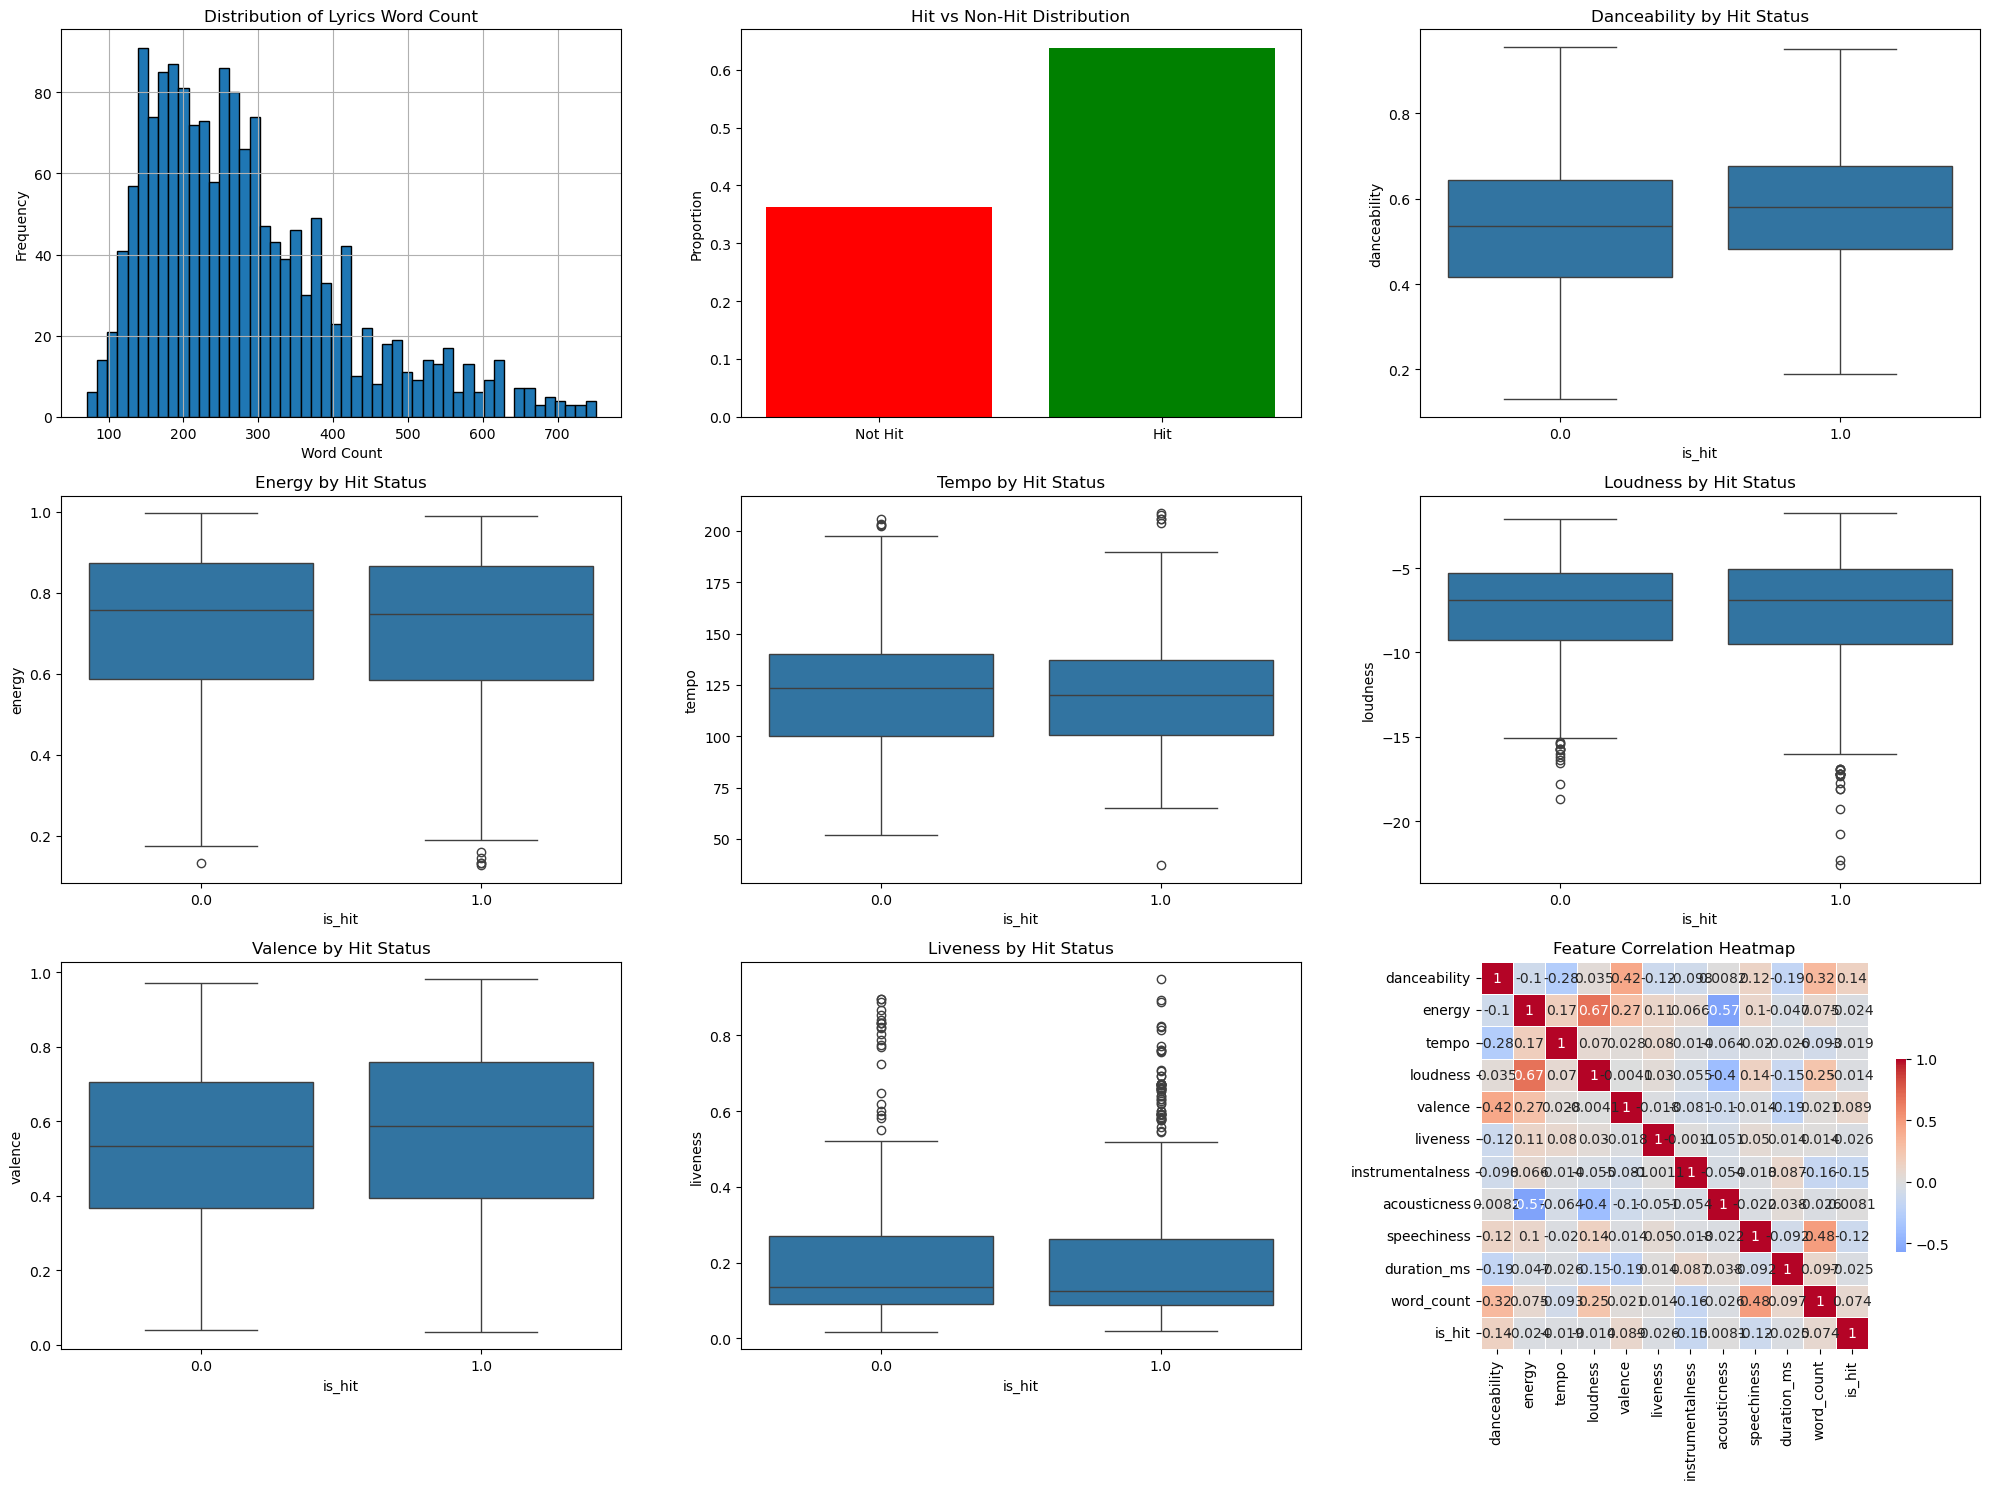


Audio Features by Hit Status:

Mean values by hit status:
        danceability    energy       tempo  loudness   valence  liveness  \
is_hit                                                                     
0.0         0.532592  0.718652  122.739771 -7.439780  0.532533  0.197920   
1.0         0.578382  0.709377  121.631172 -7.536502  0.574147  0.189433   

        instrumentalness  acousticness  speechiness    duration_ms  
is_hit                                                              
0.0             0.059397      0.142698     0.075983  252720.050420  
1.0             0.020007      0.146019     0.059851  249661.733779  

Percentage difference (Hit vs Non-Hit):
danceability: 8.6%
energy: -1.3%
tempo: -0.9%
loudness: 1.3%
valence: 7.8%
liveness: -4.3%
instrumentalness: -66.3%
acousticness: 2.3%
speechiness: -21.2%
duration_ms: -1.2%


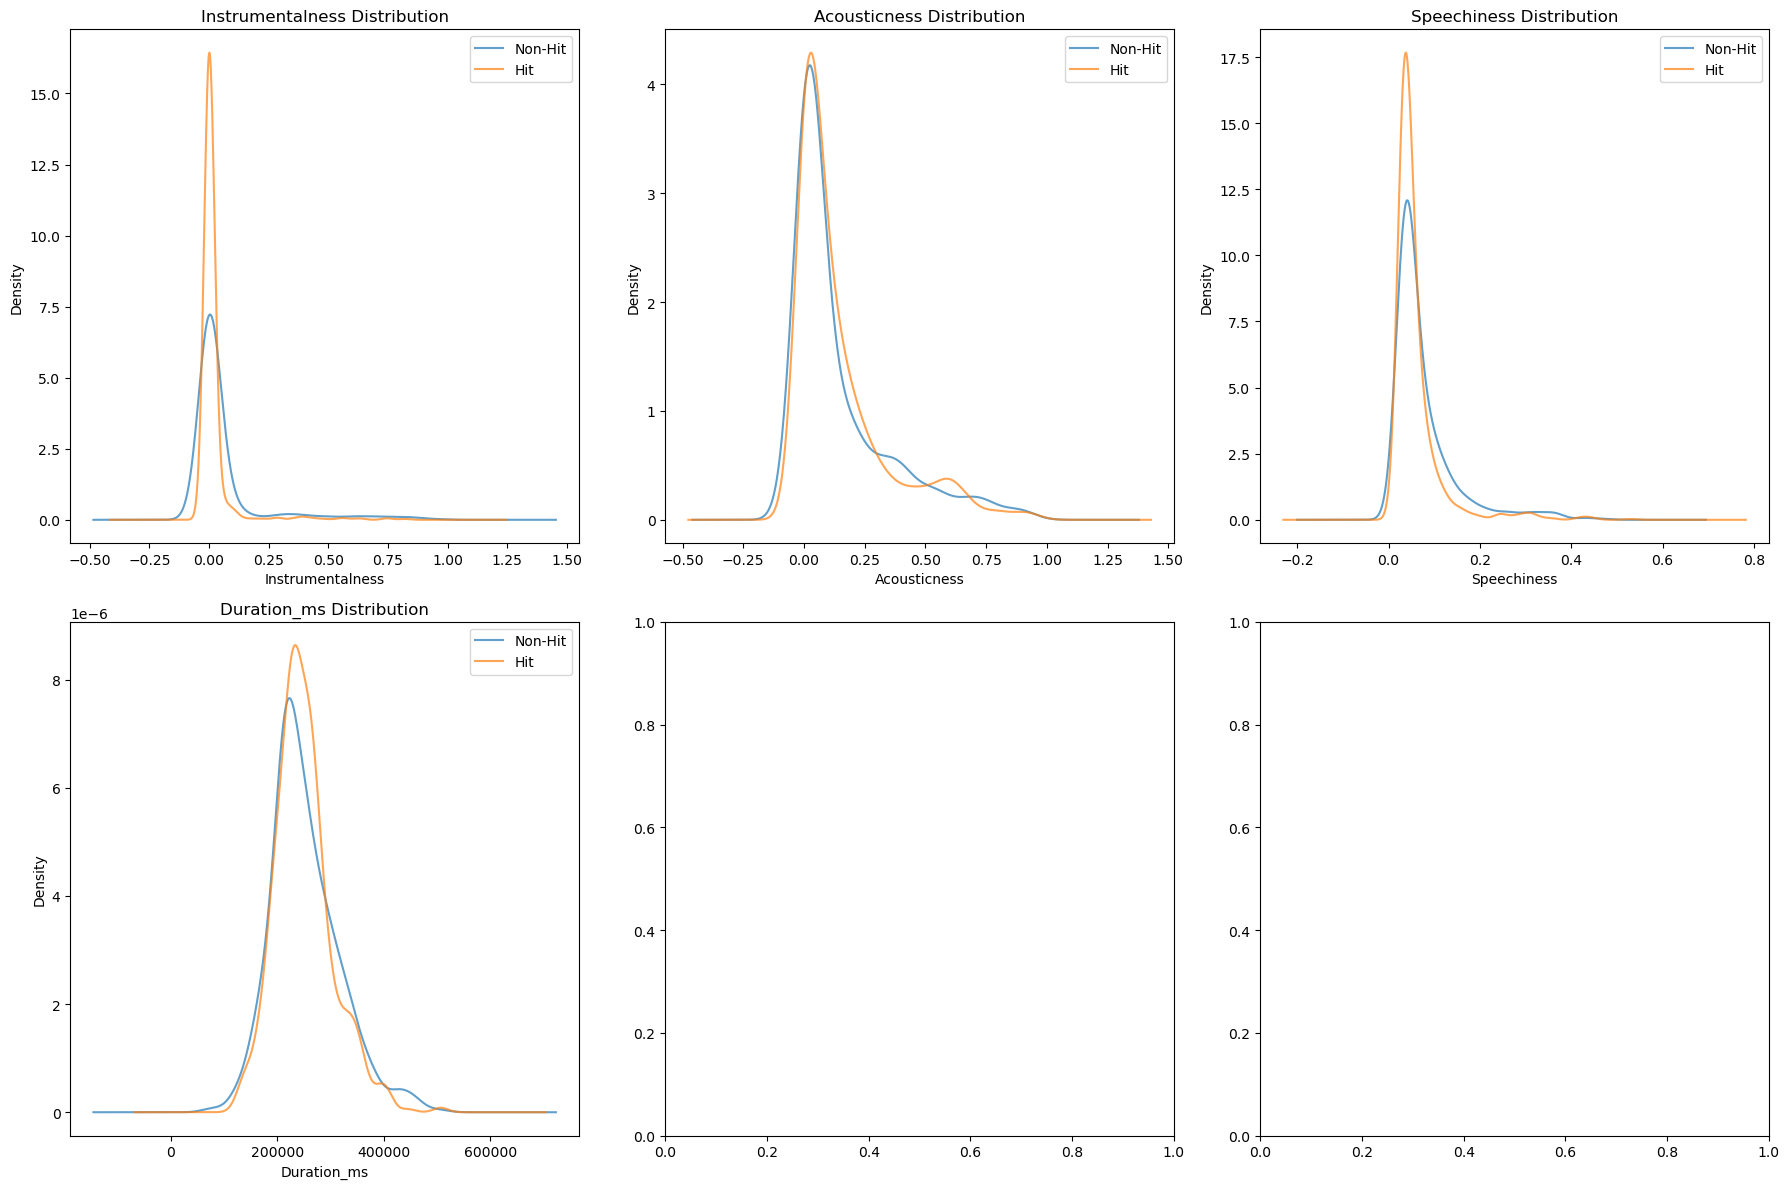


Interesting patterns:

Features with biggest differences between hits and non-hits:
instrumentalness: 66.3% difference (hits are lower)
speechiness: 21.2% difference (hits are lower)
danceability: 8.6% difference (hits are higher)
valence: 7.8% difference (hits are higher)
liveness: 4.3% difference (hits are lower)

Dataset Summary:
Total songs: 1643
Hit songs: 1048.0 (63.8%)
Non-hit songs: 595 (36.2%)
Audio features available: 10
Lyrics data available: Yes


In [26]:
df = initial_data_exploration(master_df_filtered)

### 2. Analysis
### 2.1 Classical ML pipeline




In [27]:
#this works but can maybe be optimized further
classical_results, classical_models, (X_train, X_test, y_train, y_test) = train_enhanced_classical_models(master_df_filtered)

Original class distribution:
is_hit
1.0    1048
0.0     595
Name: count, dtype: int64
Hit percentage: 63.79%

Extracting features...


/var/folders/0s/jq_rw8pn5vbbmntg97dckfwh0000gn/T/ipykernel_26704/362369061.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_lyrics'] = df['text'].apply(clean_lyrics)


Classical features shape: (1643, 17)
TF-IDF features shape: (1643, 5000)
Audio features shape: (1643, 12)

Final feature matrix shape: (1643, 5029)

Train set class distribution:
is_hit
1.0    838
0.0    476
Name: count, dtype: int64
Train hit percentage: 63.77%
Test set class distribution:
is_hit
1.0    210
0.0    119
Name: count, dtype: int64
Test hit percentage: 63.83%

Training Logistic Regression...
  Accuracy: 0.6869
  F1 Score: 0.7894
  Precision: 0.6918
  Recall: 0.9190
  ROC AUC: 0.7060
  Predictions - Non-hit: 50, Hit: 279

Training Random Forest...
  Accuracy: 0.6717
  F1 Score: 0.7939
  Precision: 0.6624
  Recall: 0.9905
  ROC AUC: 0.8559
  Predictions - Non-hit: 15, Hit: 314

Training SVM...


/opt/anaconda3/envs/hitSongPrediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hitSongPrediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hitSongPrediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

  Accuracy: 0.6383
  F1 Score: 0.7792
  Precision: 0.6383
  Recall: 1.0000
  ROC AUC: 0.6300
  Predictions - Non-hit: 0, Hit: 329

Training Gradient Boosting...
  Accuracy: 0.7720
  F1 Score: 0.8330
  Precision: 0.7824
  Recall: 0.8905
  ROC AUC: 0.8604
  Predictions - Non-hit: 90, Hit: 239

Top 20 Most Important Features (Random Forest):
                 feature  importance
5000          word_count    0.018317
5016    repetition_ratio    0.016649
5017        danceability    0.014344
5001          char_count    0.013223
5021    instrumentalness    0.013096
5002        unique_words    0.010785
5003   lexical_diversity    0.010519
5019         speechiness    0.010264
5023             valence    0.008871
5020        acousticness    0.007399
4992               youve    0.006874
35                   ahh    0.006680
5028        dance_energy    0.006654
2585                lost    0.006085
720              control    0.006064
3775                shit    0.005839
930                 dont    0.

### 2.2 LLM-Based Approach
Setting up LLM

In [2]:
print("Current directory:", os.getcwd())
print(".env exists:", os.path.exists('.env'))
WX_API_KEY = config('WX_API_KEY')
print(f"API Key: {WX_API_KEY}")

Current directory: /Users/vincentpedersen/Desktop/Uni/AIML25/HitSongPredictionExamProject
.env exists: True
API Key: idAtbfQ8FKRsJZhPAYgi0UV3sHCUxaDqtj4DCN3XMpAd


In [3]:
credentials = Credentials(
    url = "https://us-south.ml.cloud.ibm.com",
    api_key = WX_API_KEY
)

client = APIClient(
    credentials=credentials, 
    project_id="6976f984-0c65-48c4-9aa2-e9965566633b"
)

Testing that the LLM is working with a simple prompt

In [4]:
model = ModelInference(
    api_client=client,
    model_id="ibm/granite-13b-instruct-v2",
)

prompt = "How do I cook an egg?"
generated_response = model.generate(prompt)

generated_response

{'model_id': 'ibm/granite-13b-instruct-v2',
 'created_at': '2025-05-13T09:39:40.150Z',
 'results': [{'generated_text': 'To cook an egg, you just need to crack the egg open and let the white and yolk',
   'generated_token_count': 20,
   'input_token_count': 7,
   'stop_reason': 'max_tokens'}],
 'system': {'warnings': [{'message': "The value of 'parameters.max_new_tokens' for this model was set to value 20",
    'id': 'unspecified_max_new_tokens',
    'additional_properties': {'limit': 0,
     'new_value': 20,
     'parameter': 'parameters.max_new_tokens',
     'value': 0}}]}}

Model parameters

In [5]:
PARAMS = TextGenParameters(
    temperature=0,              # Higher temperature means more randomness - In this case we don't want randomness
    max_new_tokens=10,          # Maximum number of tokens to generate
    stop_sequences=[".", "\n"], # Stop generating text when these sequences are encountered
)

model = ModelInference(
    api_client=client,
    model_id="meta-llama/llama-3-405b-instruct",  # We could also try a larger model!
    params=PARAMS
)

System prompt (first is zero shot and the second is few shot)


In [19]:
SYSTEM_PROMPT_ZERO_SHOT = """You are an expert music industry analyst with decades of experience predicting chart success. Your task is to classify whether the following song will be a hit based on its lyrics and musical characteristics.

CLASSIFICATION TASK: Predict if this song will become a HIT or NOT HIT

SONG LYRICS:
{lyrics}

AUDIO CHARACTERISTICS:
{audio_features}

CLASSIFICATION INSTRUCTIONS:
1. Analyze the lyrics for:
   - Emotional appeal and relatability
   - Catchiness and memorability
   - Universal themes vs. niche content
   - Hook strength and repetition

2. Consider the audio features for:
   - Danceability and energy levels
   - Tempo and musical key
   - Production quality indicators
   - Commercial appeal factors

3. Evaluate hit potential based on:
   - Lyrical hooks and sing-along factor
   - Musical elements that drive radio play
   - Emotional connection with listeners
   - Overall commercial viability

4. Classify as either "HIT" or "NOT HIT"

Respond with ONLY one word: either "HIT" or "NOT HIT". No explanations or additional text. YOU MUST USE EXACTLY ONE OF THESE RESPONSES: HIT, NOT HIT

PREDICTION: """

In [15]:
def create_few_shot_prompt(train_df,audio_features, n_examples=5):
    """
    Create a few-shot prompt using examples from training data
    """
    # Get balanced examples
    hits = train_df[train_df['is_hit'] == 1].sample(n=n_examples//2, random_state=42)
    non_hits = train_df[train_df['is_hit'] == 0].sample(n=n_examples//2, random_state=42)
    examples = pd.concat([hits, non_hits]).sample(frac=1, random_state=42)  # Shuffle
    


    
    # Build the prompt
    prompt = "You are a music expert predicting hit songs. Here are examples:\n\n"
    
    for i, (idx, row) in enumerate(examples.iterrows(), 1):
        # Get lyrics (first 100 chars for brevity)
        lyrics_excerpt = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
        
        # Format audio features
        audio_str = ", ".join([f"{feat}: {row[feat]:.3f}" for feat in audio_features if feat in row])
        
        # Add classification
        classification = "HIT" if row['is_hit'] == 1 else "NOT HIT"
        
        prompt += f"EXAMPLE {i}:\n"
        prompt += f"Lyrics: \"{lyrics_excerpt}\"\n"
        prompt += f"Audio Features: {audio_str}\n"
        prompt += f"CLASSIFICATION: {classification}\n\n"
    
    prompt += """Now classify this new song:
Lyrics: {lyrics}
Audio Features: {audio_features}

Respond with ONLY: HIT or NOT HIT

CLASSIFICATION: """
    
    return prompt

Setup splits and features for llm

In [13]:
train, test = train_test_split(master_df_filtered, test_size=0.2, random_state=42)
audio_features = [
    'danceability', 'energy', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo'
]

In [20]:
#Zero shot predictions
predictions = []
    
for idx, song in test.iterrows():  
    
    lyrics = song["text"]  
    
    audio_features_str = ", ".join([f"{feature}: {song[feature]:.3f}" for feature in audio_features if feature in song])
    
    prompt = SYSTEM_PROMPT_ZERO_SHOT.format(
        lyrics=lyrics, 
        audio_features=audio_features_str  
    )
    

    response = model.generate(prompt)
    
    prediction = response["results"][0]["generated_text"].strip()
    
    
    predictions.append(prediction)

In [21]:
binary_predictions = [1 if pred == "HIT" else 0 for pred in predictions]
print(classification_report(test['is_hit'], binary_predictions))

              precision    recall  f1-score   support

         0.0       0.74      0.35      0.48       113
         1.0       0.73      0.94      0.82       216

    accuracy                           0.74       329
   macro avg       0.74      0.64      0.65       329
weighted avg       0.74      0.74      0.70       329



In [22]:
SYSTEM_PROMPT_FEW_SHOT = create_few_shot_prompt(train,audio_features, n_examples=6)

#Few shot predictions
predictions = []
    
for idx, song in test.iterrows():  
    
    lyrics = song["text"]  
    
    audio_features_str = ", ".join([f"{feature}: {song[feature]:.3f}" for feature in audio_features if feature in song])
    
    prompt = SYSTEM_PROMPT_FEW_SHOT.format(
        lyrics=lyrics, 
        audio_features=audio_features_str  
    )
    

    response = model.generate(prompt)
    
    prediction = response["results"][0]["generated_text"].strip()
    
    
    predictions.append(prediction)

In [23]:
binary_predictions = [1 if pred == "HIT" else 0 for pred in predictions]
print(classification_report(test['is_hit'], binary_predictions))

              precision    recall  f1-score   support

         0.0       0.53      0.35      0.42       113
         1.0       0.71      0.84      0.77       216

    accuracy                           0.67       329
   macro avg       0.62      0.59      0.60       329
weighted avg       0.65      0.67      0.65       329

